# iNaturalist 2019
### **Transfer learning from pretrained model using Keras**

As part of the FGVC6 workshop at CVPR 2019, Kaggle is conducting the iNat Challenge 2019, the large scale species classification competition, sponsored by Microsoft. It is estimated that the natural world contains several million species of plants and animals. Without expert knowledge, many of these species are extremely difficult to accurately classify due to their visual similarity. The goal of this competition is to push the state of the art in automatic image classification for real world data that features a large number of fine-grained categories.

This Kernel will use the idea of "Transfer Learning", various pre-trained model will be used be used for the problem of multiclassification.

### Librairies

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import cv2
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

import os
print(os.listdir("input"))
import json

['.DS_Store', 'kaggle_sample_submission.csv', 'test2019', 'train_val2019', 'val2019.json', 'test2019.json', 'train2019.json']


### Train dataframe

In [21]:
# make a dict,  train_anns, based on the json file
train_anns_file = 'input/train2019.json' 
with open(train_anns_file) as data:
        train_anns = json.load(data) 

In [22]:
# select only [image_id] and [category_id]
train_anns_df = pd.DataFrame(train_anns['annotations'])[['image_id','category_id']] 
# select only [id] and [filename] then rename [id] to [image_id]
train_img_df  = pd.DataFrame(train_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'}) 

# merge two dataframes on [image_id] 
df_train_file_cat = pd.merge(train_img_df, train_anns_df, on='image_id') 
df_train_file_cat['category_id']=df_train_file_cat['category_id'].astype(str)

df_train_file_cat.head()

,image_id,file_name,category_id
0,0,train_val2019/Plants/400/d1322d13ccd856eb4236c...,400
1,1,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,570
2,2,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,167
3,3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,254
4,4,train_val2019/Plants/739/ffa06f951e99de9d220ae...,739


In [23]:
print(len(df_train_file_cat['category_id'].unique()), "classes found in the dataset")

1010 classes found in the dataset


### Validation dataframe

In [24]:
valid_anns_file = 'input/val2019.json'
with open(valid_anns_file) as data:
        valid_anns = json.load(data)

In [25]:
# validation dataframe -> use after test inference to check the accuracy

valid_anns_df = pd.DataFrame(valid_anns['annotations'])[['image_id','category_id']] 

valid_anns_df.head() 

,image_id,category_id
0,265213,644
1,265214,597
2,265215,883
3,265216,300
4,265217,881


In [26]:
# validation input dataframe -> use after training

# select only [id] and [filename] then rename [id] to [image_id]
valid_img_df = pd.DataFrame(valid_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'}) 

valid_img_df.head()

,image_id,file_name
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...


In [27]:
df_valid_file_cat = pd.merge(valid_img_df, valid_anns_df, on='image_id')
df_valid_file_cat['category_id']=df_valid_file_cat['category_id'].astype(str)

df_valid_file_cat.head()

,image_id,file_name,category_id
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...,644
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...,597
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...,883
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...,300
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...,881


#### Show some images from dataset

/var/folders/wj/ptff1vp12y59z_rr8m2h5r040000gn/T/ipykernel_13083/2487789525.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  img_names = df_train_file_cat[df_train_file_cat['category_id']=='100']['file_name'][:4]


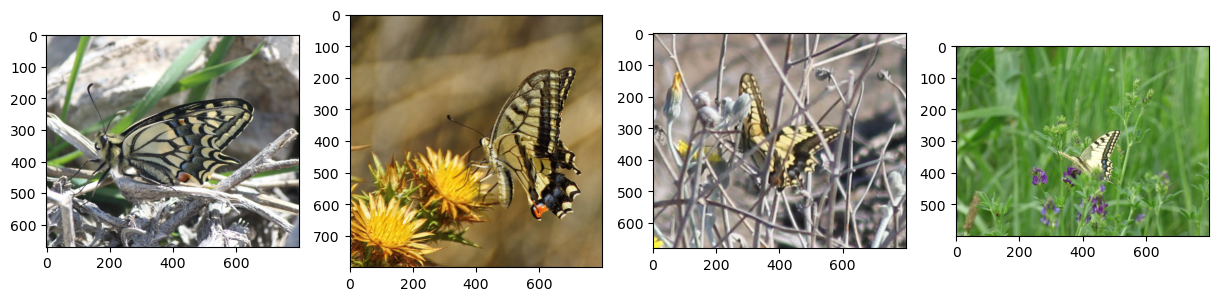

In [28]:
# Example of images for  category_id 100

img_names = df_train_file_cat[df_train_file_cat['category_id']=='100']['file_name'][:4]

plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("input/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(1, 4, i)
    plt.imshow(img)
    i += 1
plt.show()

### Settings

In [29]:
nb_classes = 1010
batch_size = 64
img_size = 80
nb_epochs = 5

###  Input data generator -> validation split, img resizing, ...

In [30]:
# Image Data Generator 
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.4)

# Fit the data to Image Data Generator
train_dataset = ImageFlow.flow_from_dataframe(dataframe=df_train_file_cat, 
                                              directory="input", 
                                              x_col="file_name", 
                                              y_col="category_id", 
                                              subset="training", 
                                              batch_size=batch_size, 
                                              seed=42, 
                                              shuffle=True, 
                                              class_mode="categorical", 
                                              target_size=(img_size,img_size))  

Found 159128 validated image filenames belonging to 1010 classes.


In [31]:
valid_dataset = ImageFlow.flow_from_dataframe(dataframe=df_valid_file_cat, 
                                              directory="input", 
                                              x_col="file_name", 
                                              y_col="category_id", 
                                              subset="validation", 
                                              batch_size=batch_size, 
                                              seed=42, 
                                              shuffle=True, 
                                              class_mode="categorical", 
                                              target_size=(img_size,img_size))

Found 1212 validated image filenames belonging to 1010 classes.


### Model

In [32]:
# base model 4 transfer learning
model = applications.Xception(weights='imagenet', 
                              include_top=False, #
                              input_shape=(img_size, img_size, 3))
#model.load_weights('../input/NASNet-large-no-top/NASNet-large-no-top.h5')
model_name = "Xception"
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 39, 39, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 39, 39, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 39, 39, 32)   0           ['block1_conv1_bn[0][0]'] 

In [33]:
# Freeze last 5 layers
for layer in model.layers[:-5]:
    layer.trainable = False

In [34]:
# old way to add cutom layers
# #Adding custom layers 
# x = model.output
# x = Flatten()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# predictions = Dense(nb_classes, activation="softmax")(x)
# model_final = Model(inputs = model.input, outputs = predictions) # wrong args names were passed here -> input instead of inputs ••• output instead of outputs

# # # use old weights
# # model_final.load_weights('vgg16_1.h5')
# # compile the model -> use only once, or if want to change the optimizer/loss/metrics
# model_final.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
#Adding custom layers 
model_final = Sequential()
model_final.add(model)
model_final.add(Flatten())
model_final.add(Dense(1024, activation='relu'))
model_final.add(Dropout(0.5))
model_final.add(Dense(nb_classes, activation='softmax'))

model_final.compile(optimizers.RMSprop(learning_rate=0.001, decay=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])

In [36]:
# Callbacks
checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [37]:
model_final.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              18875392  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 1010)              1035250   
                                                                 
Total params: 40,772,122
Trainable params: 23,077,362
Non-trainable params: 17,694,760
_________________________________________________________________


### Training

In [38]:
 # free up some memory
import gc
gc.collect();

In [39]:
# Train the model
history = model_final.fit(train_dataset,
                          epochs=nb_epochs,
                          validation_data=valid_dataset,
                          callbacks=[checkpoint,early],
                          verbose=1)

Epoch 1/5


2023-05-19 12:44:34.021780: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-19 12:44:35.335965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2487/2487 [==============================] - ETA: 0s - loss: 5.9155 - accuracy: 0.0336

2023-05-19 13:01:03.466382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2487/2487 [==============================] - 998s 400ms/step - loss: 5.9155 - accuracy: 0.0336 - val_loss: 6.3883 - val_accuracy: 0.0239
Epoch 2/5
2487/2487 [==============================] - 1026s 412ms/step - loss: 5.4274 - accuracy: 0.0577 - val_loss: 6.3482 - val_accuracy: 0.0404
Epoch 3/5
1138/2487 [============>.................] - ETA: 9:31 - loss: 5.2280 - accuracy: 0.0697

<AxesSubplot:>

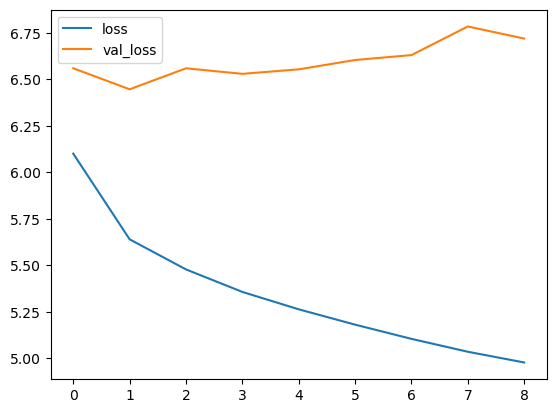

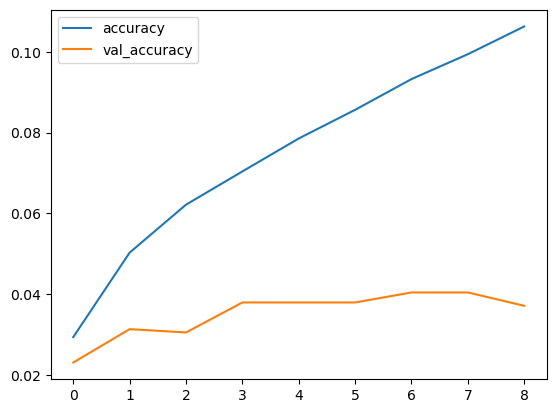

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

### Test data

In [ ]:
test_ann_file = 'input/test2019.json'
with open(test_ann_file) as data_file:
        test_anns = json.load(data_file)

In [ ]:
test_img_df = pd.DataFrame(test_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
test_img_df.head()

,image_id,file_name
0,268243,test2019/e295f3c7046b1f1e80c0301401324aa9.jpg
1,268244,test2019/ad3dcbb6846ed0b4dab58d7b1a4210ba.jpg
2,268245,test2019/e697be8e296b4b140cff4f96f85c364f.jpg
3,268246,test2019/7e7ba55e6aa26ba99e814d63b15d0121.jpg
4,268247,test2019/6cb6372079d23702511c06923970f13f.jpg


In [ ]:
# test_generator = test_datagen.flow_from_dataframe(      
    
#         dataframe=test_img_df,    
    
#         directory = "input/test2019",    
#         x_col="file_name",
#         target_size = (img_size,img_size),
#         batch_size = 1,
#         shuffle = False,
#         class_mode = None
#         )

test_dataset = ImageFlow.flow_from_dataframe(dataframe=test_img_df, 
                                              directory="input", 
                                              x_col="file_name", 
                                        #     y_col="category_id",  
                                              batch_size = 1, 
                                              seed=42, 
                                              shuffle = False, 
                                              class_mode = None, 
                                              target_size=(img_size,img_size))

Found 35350 validated image filenames.


### Prediction

In [ ]:
gc.collect();

In [ ]:
test_generator.reset()
predict=model_final.predict_generator(test_generator, steps = len(test_generator.filenames))

In [ ]:
len(predict)

In [ ]:
predicted_class_indices=np.argmax(predict,axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
sam_sub_df = pd.read_csv('input/kaggle_sample_submission.csv')
sam_sub_df.head()

,id,predicted
0,268243,842
1,268244,139
2,268245,988
3,268246,612
4,268247,468


In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted":predictions})
df_res = pd.merge(test_img_df, results, on='file_name')[['image_id','predicted']]\
    .rename(columns={'image_id':'id'})

df_res.head()

In [ ]:
df_res.to_csv("submission.csv",index=False)